### Project Description : This is competition hosted by Data Driven. The objective is to predict which water pumps are functional, which need some repairs, and which don't work at all, a multiclass classifcation problem. The model produced managed to get 81.06% accuracy on test data, currently on top 14% of the leaderboeard.

#### 1. Import Dependencies Library

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from fancyimpute import IterativeImputer as MICE
from datetime import datetime

### 2. Load train & test set data

In [233]:
df_train = pd.read_csv("/train_taarifa.csv",parse_dates=True)
y_train = pd.read_csv("/y_train.csv")
df_test = pd.read_csv("/test_taarifa.csv",parse_dates=True)
df_full = pd.concat([df_train,df_test],sort=False).drop('status_group',axis=1)

df_train_index = df_train.index.values
df_test_index = df_test.index.values

print(df_full.shape)
print(df_train.shape)
print(y_train.shape)
print(df_test.shape)

(74250, 40)
(59400, 41)
(59400, 2)
(14850, 40)


### 3. Exploratory Data Analysis

In [71]:
df_train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [72]:
# Check if there is any missing data
# There are 7 columns with missing data
df_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [26]:
# Check the counts of target variable

df_train.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

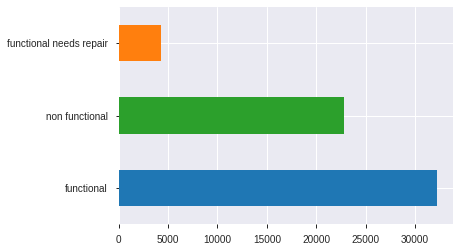

In [237]:
# Plot the bar chart to visualize target "status_group"

palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]
y_train.status_group.value_counts().plot(kind='barh', color=palette)

Text(0.5, 0, 'Construction Year')

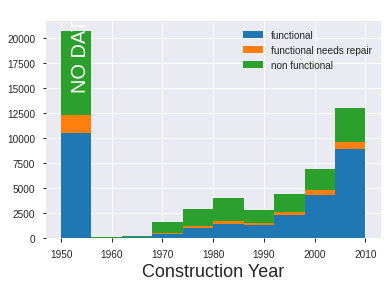

In [243]:
# Plot the bar chart to visualize target "status_group" & relationship with "construction_year"

df_train.construction_year=pd.to_numeric(df_train.construction_year)
df_train.loc[df_train.construction_year <= 0, df_train.columns=='construction_year'] = 1950

hist1=df_train[df_train.status_group == 'functional'].construction_year
hist2=df_train[df_train.status_group == 'functional needs repair'].construction_year
hist3=df_train[df_train.status_group == 'non functional'].construction_year

n,b,p=plt.hist([hist1, hist2, hist3], stacked=True,range=[1950,2010])
plt.legend(['functional','functional needs repair','non functional'],loc=0)
plt.text(1952, 15000,'NO DATA',fontsize=20,rotation=90,color='white')
plt.xlabel('Construction Year', fontsize=18)


In [0]:
#convert status group label into numerical data

val_status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
df_train['status_group_vals']=df_train.status_group.replace(val_status_group)

##### Remove the field which has too many redundant values/ categories

### 3. Data Transformation - Part 1

In [0]:
# Divide all categorical columns into max 5 categories, else as others
# This will helps in model convergence
def funder_cleaning(train):
    if train['funder']=='Government Of Tanzania':
        return 'government'
    elif train['funder']=='Danida':
        return 'danida'
    elif train['funder']=='Hesawa':
        return 'hesawa'
    elif train['funder']=='Rwssp':
        return 'rwssp'
    elif train['funder']=='World Bank':
        return 'world_bank'    
    else:
        return 'other'
    
df_train['funder']= df_train.apply(lambda row: funder_cleaning(row), axis=1)
df_test['funder']= df_test.apply(lambda row: funder_cleaning(row), axis=1)

In [0]:
def installer_cleaning(train):
    if train['installer']=='DWE':
        return 'dwe'
    elif train['installer']=='Government':
        return 'government'
    elif train['installer']=='RWE':
        return 'rwe'
    elif train['installer']=='Commu':
        return 'commu'
    elif train['installer']=='DANIDA':
        return 'danida'    
    else:
        return 'other'
    
df_train['installer']= df_train.apply(lambda row: installer_cleaning(row), axis=1)
df_test['installer']= df_test.apply(lambda row: installer_cleaning(row), axis=1)

In [0]:
def scheme_wrangler(row):
    '''Keep top 5 values and set the rest to 'other'. '''
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    else:
        return 'other'

df_train['scheme_management'] = df_train.apply(lambda row: scheme_wrangler(row), axis=1)
df_test['scheme_management'] = df_test.apply(lambda row: scheme_wrangler(row), axis=1)

In [0]:
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
df_train['construction_year'] = df_train.apply(lambda row: construction_wrangler(row), axis=1)
df_test['construction_year'] = df_test.apply(lambda row: construction_wrangler(row), axis=1)

##### Drop the columns which are redundant columns with too many unique values, this would not bring any goods to model

In [0]:
# Eg. A few pairs of variables are similar :
# (waterpoint_type,waterpoint_type_group) & (source & source type) & etcs both are almost similar, can drop one of them

df_train=df_train.drop(['subvillage','scheme_name','recorded_by','waterpoint_type','source','quantity',
                        'payment','management','extraction_type','extraction_type_group'],axis=1)
df_test=df_test.drop(['subvillage','scheme_name','recorded_by','waterpoint_type','source','quantity',
                      'payment','management','extraction_type','extraction_type_group'],axis=1)

##### Fill the valid columns with blank value - "Unknown"/"Other"

In [0]:
#Since most of the values are True, as of now lets insert True for the missing values. Scope to alter the values in future
df_train.public_meeting = df_train.public_meeting.fillna('Unknown')
df_test.public_meeting = df_test.public_meeting.fillna('Unknown')

In [0]:
df_train.scheme_management = df_train.scheme_management.fillna('other')
df_test.scheme_management = df_test.scheme_management.fillna('other')

In [0]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

df_train.permit = df_train.permit.fillna('Unknown')
df_test.permit = df_test.permit.fillna('Unknown')

In [184]:
#EDA
# Checking Null Values on test data
df_train.apply(lambda x: sum(x.isnull()), axis=0)

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quality_group            0
quantity_group           0
source_type              0
source_class             0
waterpoint_type_group    0
status_group             0
status_group_vals        0
dtype: int64

In [185]:
# Statistics for full train/test dataset
df_full.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [0]:
### Imputation for invalid value 0 in numerical column with mean/median

# amount_tsh median equal to 0, no replacement done in first consideration 

def population_cleaning(train):
    if train['population']==0:
        return 25 #replace with median, skewed data
    else:
        return train['population']

def gpsheight_cleaning(train):
    if train['gps_height']==0:
        return 364 #replace with median, skewed data
    else:
        return train['gps_height']

def longitude_cleaning(train):
    if train['longitude']==0:
        return 34.074262
    else:
        return train['longitude']

df_train['population']= df_train.apply(lambda row: population_cleaning(row), axis=1)
df_test['population']= df_test.apply(lambda row: population_cleaning(row), axis=1)
df_train['gps_height']= df_train.apply(lambda row: gpsheight_cleaning(row), axis=1)
df_test['gps_height']= df_test.apply(lambda row: gpsheight_cleaning(row), axis=1)
df_train['longitude']= df_train.apply(lambda row: longitude_cleaning(row), axis=1)
df_test['longitude']= df_test.apply(lambda row: longitude_cleaning(row), axis=1)

### Feature engineering: Days since recorded can be useful to know the period of pump installed

In [187]:
df_train.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(df_train.date_recorded)
df_train.columns = ['days_since_recorded' if x == 'date_recorded' else x for x in df_train.columns]
df_train.days_since_recorded = df_train.days_since_recorded.astype('timedelta64[D]').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [188]:
df_test.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(df_test.date_recorded)
df_test.columns = ['days_since_recorded' if x == 'date_recorded' else x for x in df_test.columns]
df_test.days_since_recorded = df_test.days_since_recorded.astype('timedelta64[D]').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [189]:
# Data is clean for model training
# not too correlated to each other, good fit for model
df_train.corr()

,id,amount_tsh,days_since_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,status_group_vals
id,1.000000,-0.005321,-0.003174,-0.004620,0.001732,0.001718,-0.002629,-0.003028,-0.003044,-0.002820,-0.004049
amount_tsh,-0.005321,1.000000,0.016346,0.068750,0.013681,-0.052670,0.002944,-0.026813,-0.023599,0.014918,0.053702
days_since_recorded,-0.003174,0.016346,1.000000,-0.221907,-0.026283,-0.231637,0.018206,-0.155157,0.016448,-0.103364,0.031476
gps_height,-0.004620,0.068750,-0.221907,1.000000,-0.146137,0.038021,0.001484,-0.234831,-0.224710,0.075306,0.124133
longitude,0.001732,0.013681,-0.026283,-0.146137,1.000000,-0.304252,0.045264,0.145185,0.254975,0.054591,-0.004995
latitude,0.001718,-0.052670,-0.231637,0.038021,-0.304252,1.000000,0.006837,-0.221018,-0.201020,-0.017276,0.014547
num_private,-0.002629,0.002944,0.018206,0.001484,0.045264,0.006837,1.000000,-0.020377,-0.004478,0.003100,0.005021
region_code,-0.003028,-0.026813,-0.155157,-0.234831,0.145185,-0.221018,-0.020377,1.000000,0.678602,0.093234,-0.108640
district_code,-0.003044,-0.023599,0.016448,-0.224710,0.254975,-0.201020,-0.004478,0.678602,1.000000,0.059890,-0.065687
population,-0.002820,0.014918,-0.103364,0.075306,0.054591,-0.017276,0.003100,0.093234,0.059890,1.000000,0.017454


In [0]:
#water_quality and quality_group are correlated . drop one of them
df_train=df_train.drop(['quality_group'],axis=1)
df_test=df_test.drop(['quality_group'],axis=1)

In [0]:
# Lastly drop those variable that seem superflous like 'num_private' & 'wpt_name which no extra info
df_train1 = df_train.copy()
df_train = df_train.drop(['num_private','wpt_name','lga','region','ward','status_group'], axis=1)

df_test = df_test.drop(['num_private','wpt_name','lga','region','ward'], axis=1)

##### One-hot encoding for categorical data

In [0]:
# Get dummy columns for the categorical columns and shuffle the data.

dummy_cols = ['funder', 'installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
              'construction_year', 'extraction_type_class','management_group', 'payment_type', 'water_quality',
              'quantity_group', 'source_type', 'source_class','waterpoint_type_group']

df_train = pd.get_dummies(df_train, columns = dummy_cols)

df_train = df_train.sample(frac=1).reset_index(drop=True)

In [0]:
df_test = pd.get_dummies(df_test, columns = dummy_cols)

In [194]:
print('Shape of training data',df_train.shape)
print('Shape of testing data',df_test.shape)

Shape of training data (59400, 98)
Shape of testing data (14850, 97)


In [93]:
df_train.corr()

,id,amount_tsh,days_since_recorded,gps_height,longitude,latitude,region_code,district_code,population,status_group_vals,funder_danida,funder_government,funder_hesawa,funder_other,funder_rwssp,funder_world_bank,installer_commu,installer_danida,installer_dwe,installer_government,installer_other,installer_rwe,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,public_meeting_False,public_meeting_True,public_meeting_Unknown,scheme_management_other,scheme_management_vwc,scheme_management_wtr_auth,scheme_management_wtr_brd,scheme_management_wua,scheme_management_wug,...,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
id,1.000000,-0.005321,-0.003174,-0.004692,-0.001348,0.001718,-0.003028,-0.003044,-0.002813,-0.004049,0.002990,0.006442,0.002381,-0.001346,-0.007967,-0.010926,-0.000421,0.008085,-0.006471,0.004837,0.002384,-0.000397,-0.003979,0.004031,-0.000222,-0.008958,0.008727,0.004043,-0.001548,0.002762,-0.006322,-0.004359,0.000923,0.003887,-0.002795,0.006661,-0.001713,-0.002129,-0.002587,-0.003050,...,0.002714,0.000479,-0.001876,-0.002146,-0.000302,-0.003308,0.003446,0.003059,-0.001165,-0.005035,0.002075,-0.001933,0.007722,0.002139,-0.006214,0.003804,0.002736,-0.003546,0.002332,0.000745,0.000910,-0.002174,0.001678,-0.001364,0.006145,-0.003303,0.004200,-0.004289,-0.004782,-0.002903,0.003419,0.006427,-0.007162,0.004200,0.005958,-0.000481,0.001272,0.003654,0.010570,-0.009403
amount_tsh,-0.005321,1.000000,0.016346,0.076650,0.022134,-0.052670,-0.026813,-0.023599,0.016288,0.053702,0.040410,-0.016381,-0.019273,0.008815,-0.015492,-0.007610,0.002080,0.006839,-0.000394,-0.004593,0.002643,-0.010546,-0.012888,0.022013,0.009353,-0.012452,-0.043650,-0.002865,0.053660,-0.008518,0.005554,-0.015798,0.025683,-0.019708,-0.012218,-0.000422,0.006709,-0.009845,0.048960,-0.019273,...,-0.011005,0.026322,-0.008443,-0.005508,0.187301,0.080813,-0.090005,-0.000151,0.000393,-0.038871,-0.042194,-0.004544,0.009043,-0.001793,-0.011569,-0.016959,-0.007483,0.025394,-0.014085,-0.021527,0.036329,-0.013098,-0.018309,-0.009732,-0.000474,-0.006881,-0.005682,-0.020510,0.054273,-0.047746,0.013612,-0.037000,0.038201,-0.005682,-0.004586,0.039472,-0.001150,-0.019800,-0.005608,-0.030951
days_since_recorded,-0.003174,0.016346,1.000000,-0.254247,0.036293,-0.231637,-0.155157,0.016448,-0.109340,0.031476,0.051584,-0.023850,0.069737,-0.004428,-0.092852,-0.000844,0.140888,-0.073671,0.056404,-0.063712,-0.063979,0.052658,-0.252875,0.166099,0.140583,-0.222702,0.062979,-0.200840,0.374527,-0.278340,0.245844,-0.031453,0.136728,-0.168746,-0.069250,0.257797,-0.168394,-0.149990,0.086631,-0.177309,...,-0.062287,-0.085723,-0.042844,0.091958,0.092176,0.017414,0.167025,0.059756,-0.075797,-0.081134,-0.251343,0.030204,-0.036092,-0.007434,-0.048212,0.007911,-0.040357,0.034036,-0.034525,-0.001609,0.071753,-0.072148,-0.008121,-0.014446,-0.075876,-0.036400,0.022830,-0.067731,0.079681,0.029291,0.005004,-0.035591,0.032116,0.022830,-0.026547,0.023067,0.006520,0.025507,-0.0

In [0]:
#profiling report of training data
#pandas_profiling.ProfileReport(df_train)

#from profiling report, we can drop duplicate rows from the training dataset and also we can see 
#waterpoint_type_group_hand pump is highly correlated with extraction_type_class_handpump. we can drop any one of the column

#train=train.drop_duplicates()

df_train=df_train.drop(['waterpoint_type_group_hand pump'],axis=1)
df_test=df_test.drop(['waterpoint_type_group_hand pump'],axis=1)

df_train=df_train.drop(['source_type_other'],axis=1)
df_test=df_test.drop(['source_type_other'],axis=1)


In [0]:
# Define Y & drop it from the train set for feature selection
target = df_train.status_group_vals
features = df_train.drop('status_group_vals', axis=1)

features1=features.copy()

### 4. Feature Selection (Using boruta package)

In [0]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [101]:
# RandomForrestClassifier as the estimator to use for Boruta. 
# The max_depth of the tree is advised on the Boruta Github page to be between 3 to 7

rf = RandomForestClassifier(criterion='gini',
                                n_estimators=500,
                                max_features='auto',
                                oob_score=True,
                                random_state=1,
                                n_jobs=-1,
                                max_depth=6)

X_boruta=features.values
y_boruta=target.values

boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)
start_time = timer(None)
boruta_selector.fit(X_boruta,y_boruta)
timer(start_time)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	95
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	72
Tentative: 	10
Rejected: 	13
Iteration: 	9 / 100
Confirmed: 	72
Tentative: 	10
Rejected: 	13
Iteration: 	10 / 100
Confirmed: 	72
Tentative: 	10
Rejected: 	13
Iteration: 	11 / 100
Confirmed: 	72
Tentative: 	10
Rejected: 	13
Iteration: 	12 / 100
Confirmed: 	73
Tentative: 	9
Rejected: 	13
Iteration: 	13 / 100
Confirmed: 	73
Tentative: 	9
Rejected: 	13
Iteration: 	14 / 100
Confirmed: 	73
Tentative: 	7
Rejected: 	15
Iteration: 	15 / 100
Confirmed: 	73
Tentative: 	7
Rejected: 	15
Iteration: 	16 / 100
Confirmed: 	74
Tentative: 	6
Re

In [102]:
# number of selected features
print ('\n Number of selected features:')
print (boruta_selector.n_features_)


 Number of selected features:
75


In [118]:
features1=pd.DataFrame(features.columns.tolist())
features1['rank']=boruta_selector.ranking_
features1 = features1.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (features1.head(boruta_selector.n_features_))

#From Boruta, we retained the 70 columns. The remaining columns whose rank is greater than 1 is not required.


 Top 75 features:
                                    0  rank
0               construction_year_90s     1
1               payment_type_annually     1
2         management_group_user-group     1
3         management_group_commercial     1
4   extraction_type_class_submersible     1
..                                ...   ...
70         scheme_management_wtr_auth     1
71                   basin_Lake Rukwa     1
72          scheme_management_wtr_brd     1
73              basin_Lake Tanganyika     1
74      basin_Ruvuma / Southern Coast     1

[75 rows x 2 columns]


In [120]:
features1=pd.DataFrame(features.columns.tolist())
features1['rank']=boruta_selector.ranking_
features1 = features1.sort_values('rank', ascending=True).reset_index(drop=True)
features1

,0,rank
0,construction_year_90s,1
1,payment_type_annually,1
2,management_group_user-group,1
3,management_group_commercial,1
4,extraction_type_class_submersible,1
...,...,...
90,water_quality_coloured,16
91,extraction_type_class_wind-powered,18
92,waterpoint_type_group_cattle trough,18
93,waterpoint_type_group_dam,19


In [0]:
#Drop columns which Boruta didnt give/predict rank 1 importance

df_train=features.drop(['water_quality_milky'
    ,'source_type_dam'
    ,'payment_type_on failure'
    ,'funder_hesawa'
    ,'construction_year_60s'
    ,'management_group_parastatal'
    ,'water_quality_salty abandoned'
    ,'management_group_unknown'
    ,'management_group_other'
    ,'extraction_type_class_rope pump'
    ,'payment_type_other'
    ,'installer_danida'
    ,'water_quality_fluoride'
    ,'source_class_unknown'
    ,'water_quality_coloured'
    ,'extraction_type_class_wind-powered'
    ,'waterpoint_type_group_cattle trough'
    ,'waterpoint_type_group_dam'
    ,'water_quality_fluoride abandoned'],axis=1)

df_test=df_test.drop(['water_quality_milky'
    ,'source_type_dam'
    ,'payment_type_on failure'
    ,'funder_hesawa'
    ,'construction_year_60s'
    ,'management_group_parastatal'
    ,'water_quality_salty abandoned'
    ,'management_group_unknown'
    ,'management_group_other'
    ,'extraction_type_class_rope pump'
    ,'payment_type_other'
    ,'installer_danida'
    ,'water_quality_fluoride'
    ,'source_class_unknown'
    ,'water_quality_coloured'
    ,'extraction_type_class_wind-powered'
    ,'waterpoint_type_group_cattle trough'
    ,'waterpoint_type_group_dam'
    ,'water_quality_fluoride abandoned'],axis=1)



In [198]:
print(df_train.shape)
print(df_test.shape)

(59400, 76)
(14850, 76)


In [0]:
# # Invalid value like 0 in some columns detected, will be imputed with IterativeImputer later

# def population_cleaning(train):
#     if train['population']==0:
#         return np.nan
#     else:
#         return train['population']

# def gpsheight_cleaning(train):
#     if train['gps_height']==0:
#         return np.nan
#     else:
#         return train['gps_height']

# def longitude_cleaning(train):
#     if train['longitude']==0:
#         return np.nan
#     else:
#         return train['longitude']

# def amounttsh_cleaning(train):
#     if train['amount_tsh']==0:
#         return np.nan
#     else:
#         return train['amount_tsh']

# df_train['population']= df_train.apply(lambda row: population_cleaning(row), axis=1)
# df_test['population']= df_test.apply(lambda row: population_cleaning(row), axis=1)
# df_train['gps_height']= df_train.apply(lambda row: gpsheight_cleaning(row), axis=1)
# df_test['gps_height']= df_test.apply(lambda row: gpsheight_cleaning(row), axis=1)
# df_train['longitude']= df_train.apply(lambda row: longitude_cleaning(row), axis=1)
# df_test['longitude']= df_test.apply(lambda row: longitude_cleaning(row), axis=1)
# df_train['amount_tsh']= df_train.apply(lambda row: amounttsh_cleaning(row), axis=1)
# df_test['amount_tsh']= df_test.apply(lambda row: amounttsh_cleaning(row), axis=1)

In [150]:
# # Check and see if there is missing value now as those invalid value 0 has been replaced with np.nan
# df_train.isnull().sum()

id                                              0
amount_tsh                                  41639
days_since_recorded                             0
gps_height                                  20438
longitude                                    1812
                                            ...  
source_class_groundwater                        0
source_class_surface                            0
waterpoint_type_group_communal standpipe        0
waterpoint_type_group_improved spring           0
waterpoint_type_group_other                     0
Length: 76, dtype: int64

In [0]:
# to test out normalization and scaler
df_train1 = df_train.copy()
df_test1 = df_test.copy()

### 5. Split Data into train & validation set

In [0]:
X_train, X_val, y_train, y_val = train_test_split(df_train1, target, train_size=0.9, random_state=100)

##### Perform Data Transformation - Part 2 (after train_test_split)

##### In this case, IterativeImputer only manage to give accuracy of 80.4% hence will no proceed.

In [153]:
# # FancyImpute with MICE
# # Default method used is BayesianRidge

# # Use Logistic regression as the baseline
# logreg = make_pipeline(RobustScaler(), LogisticRegression())

# # Impute invalid/missing value
# # Fit_transform on training set
# mice = MICE(verbose=0)
# X_train_fancy_mice = mice.fit_transform(X_train)
# scores = cross_val_score(logreg, X_train_fancy_mice, y_train, cv=10)
# scores.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

0.7285634118967452

In [155]:
# # Then apply transformation to validation and test dataset to avoid data leakage
# col_list = X_train.columns.tolist()
# X_train_mice = pd.DataFrame(X_train_fancy_mice, columns=col_list)
# print(X_train_mice.shape)

# X_train_mice.head()

(53460, 76)


,id,amount_tsh,days_since_recorded,gps_height,longitude,latitude,region_code,district_code,population,funder_danida,funder_government,funder_other,funder_rwssp,funder_world_bank,installer_commu,installer_dwe,installer_government,installer_other,installer_rwe,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,public_meeting_False,public_meeting_True,public_meeting_Unknown,scheme_management_other,scheme_management_vwc,scheme_management_wtr_auth,scheme_management_wtr_brd,scheme_management_wua,scheme_management_wug,permit_False,permit_True,permit_Unknown,construction_year_00s,construction_year_10s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_submersible,management_group_commercial,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_per bucket,payment_type_unknown,water_quality_salty,water_quality_soft,water_quality_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,waterpoint_type_group_communal standpipe,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,61731.0,739.409176,263.0,993.0,36.798678,-3.493768,2.0,2.0,300.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,48281.0,2000.000000,873.0,1133.0,31.159952,-6.374470,15.0,1.0,240.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37715.0,-682.719184,1029.0,760.0,30.576431,-6.998989,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,27455.0,750.000000,123.0,1071.0,29.872486,-4.621343,16.0,2.0,1500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,62597.0,1171.586141,961.0,1599.0,35.121040,-9.248569,11.0,4.0,480.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [156]:
# # Check and see if there is missing value after MICE imputation
# # The invalid value has been imputed
# X_train_mice.isnull().sum()

id                                          0
amount_tsh                                  0
days_since_recorded                         0
gps_height                                  0
longitude                                   0
                                           ..
source_class_groundwater                    0
source_class_surface                        0
waterpoint_type_group_communal standpipe    0
waterpoint_type_group_improved spring       0
waterpoint_type_group_other                 0
Length: 76, dtype: int64

In [157]:
# # Apply transformation on validation & test dataset

# X_val_fancy_mice = mice.transform(X_val)
# df_test_fancy_mice = mice.transform(df_test)

# X_val_mice = pd.DataFrame(X_val_fancy_mice, columns=col_list)
# df_test_mice = pd.DataFrame(df_test_fancy_mice, columns=col_list)
# print(X_val_mice.shape)
# print(df_test_mice.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(5940, 76)
(14850, 76)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

##### Data Normalization

In [0]:
# Columns intended for normalization
df_num_cols=['amount_tsh','days_since_recorded','longitude','region_code', 'latitude',                      
'district_code','population']

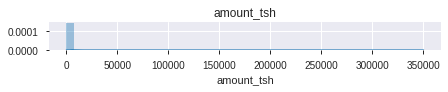

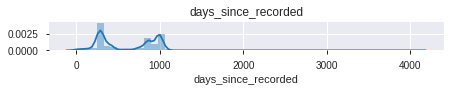

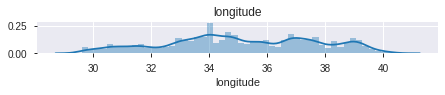

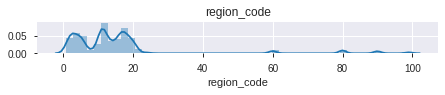

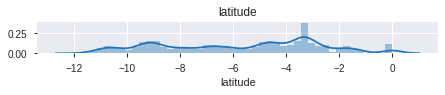

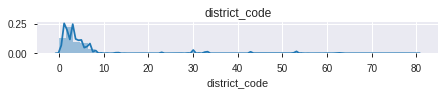

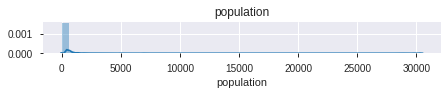

In [202]:
# Plot the distribution of numerical columns

for i, col in enumerate(df_num_cols):
    plt.figure(figsize=(12,5))
    plt.subplot(5, 2, i + 1)
    sns.distplot(XS_train[col])
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    plt.tight_layout()
    plt.show()
plt.show()

In [0]:
# # fig=plt.figure(figsize=(20,20))
# for i, col in enumerate(df_full[numeric_col]):
#     # ax = fig.add_subplot(2,6,i+1)
#     plt.figure(i)
#     sns.distplot(df_full[col])

# # fig.tight_layout()
# # plt.show()

In [218]:
# Do normalization and scaling

# Train set normalization
X_train.amount_tsh = X_train.amount_tsh.apply(lambda x: np.log10(x+1))
X_train.days_since_recorded = X_train.days_since_recorded.apply(lambda x: np.log10(x+1))
X_train.longitude = X_train.longitude.apply(lambda x: np.log10(x+1))
X_train.region_code = X_train.region_code.apply(lambda x: np.log10(x+1))
X_train.district_code = X_train.district_code.apply(lambda x: np.log10(x+1))
X_train.population = X_train.population.apply(lambda x: np.log10(x+1))


# Validation set normalization
X_val.amount_tsh = X_val.amount_tsh.apply(lambda x: np.log10(x+1))
X_val.days_since_recorded = X_val.days_since_recorded.apply(lambda x: np.log10(x+1))
X_val.longitude = X_val.longitude.apply(lambda x: np.log10(x+1))
X_val.region_code = X_val.region_code.apply(lambda x: np.log10(x+1))
X_val.district_code = X_val.district_code.apply(lambda x: np.log10(x+1))
X_val.population = X_val.population.apply(lambda x: np.log10(x+1))

# Test set normalization
df_test1.amount_tsh = df_test.amount_tsh.apply(lambda x: np.log10(x+1))
df_test1.days_since_recorded = df_test.days_since_recorded.apply(lambda x: np.log10(x+1))
df_test1.longitude = df_test.longitude.apply(lambda x: np.log10(x+1))
df_test1.region_code = df_test.region_code.apply(lambda x: np.log10(x+1))
df_test1.district_code = df_test.district_code.apply(lambda x: np.log10(x+1))
df_test1.population = df_test.population.apply(lambda x: np.log10(x+1))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
df_train1=df_train1.fillna(df_train1.mean())
df_test1=df_test1.fillna(df_test1.mean())

# X_train_mice=X_train_mice.fillna(X_train_mice.mean())
# X_val_mice=X_val_mice.fillna(X_val_mice.mean())

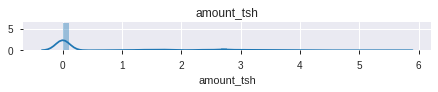

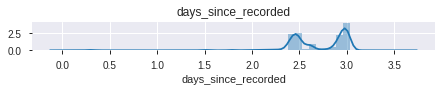

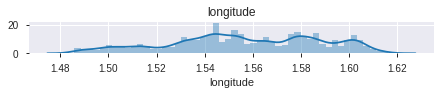

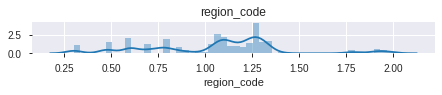

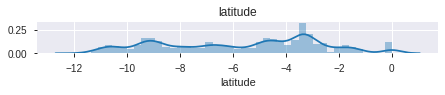

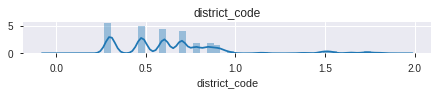

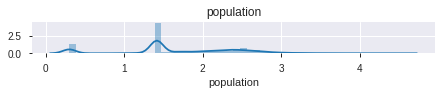

In [204]:
# Data distribution after normalization

for i, col in enumerate(df_num_cols):
    plt.figure(figsize=(12,5))
    plt.subplot(5, 2, i + 1)
    sns.distplot(X_train[col])
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    plt.tight_layout()
    plt.show()
plt.show()

##### Data Scaling

In [219]:
# Scale the numerical variables can help model find pattern and faster convergence
# Tree-like algorithms is still prone to unnormalized/unscaled data due to bagging & boosting
rs =RobustScaler()

# Fit_transform should be done on only training data to avoid data leakage problem
X_train[df_num_cols] = rs.fit_transform(X_train[df_num_cols])

X_val[df_num_cols] = rs.transform(X_val[df_num_cols])
df_test1[df_num_cols] = rs.transform(df_test1[df_num_cols])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

##### Data are now good to proceed to model training ...

### 6. Model Training

##### Hyperparameter tuning with GridSearchCV

In [0]:
# Model 1 : Linear Kernel SVM Classifier

def Linear_svc_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        #scl = StandardScaler()
        clf = LinearSVC()
        
        parameters = {'C':[0.001,0.01,0.1,1.0,10.0,100.0],'class_weight':[None, 'balanced']}

        estimator = GridSearchCV(clf, parameters,n_jobs=-1)

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [142]:
Linear_svc_model(X_train, X_val, y_train, y_val)

Validation accuracy:  0.4348484848484849
{'C': 0.1, 'class_weight': 'balanced'}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
# Model 2 : GBM

def GradientBoostingClassifier_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        
        gb = GradientBoostingClassifier()
        
        parameters = {'learning_rate': [0.1],
                     'max_depth': [10],
                     'min_samples_leaf': [16],
                     "min_samples_split" : [8,12,16],
                    #  'max_features': ["log2","sqrt"],
                     "subsample":[0.5, 0.8, 0.95],
                     'n_estimators': [200]}
        
        estimator = GridSearchCV(gb,n_jobs=-1,param_grid=parameters)
        
        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [0]:
GradientBoostingClassifier_model(X_train, X_val, y_train, y_val)

Validation accuracy:  0.7977272727272727
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.6, 'min_samples_leaf': 16, 'min_samples_split': 8, 'n_estimators': 200, 'subsample': 0.95}


In [0]:
# Model 3 : Random Forest

def RandomForestClassifier_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        
        rf = RandomForestClassifier()
        
        parameters = {'max_samples' : [0.8],
                      'max_depth': [16,22],
                      'n_estimators': [500,1000]}
        
        estimator = GridSearchCV(rf,n_jobs=-1,param_grid=parameters,verbose=2,cv=5)

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [228]:
RandomForestClassifier_model(X_train, X_val, y_train, y_val) 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.7min finished


Validation accuracy:  0.8213804713804714
{'max_depth': 22, 'max_samples': 0.8, 'n_estimators': 1000}


In [220]:
rf = RandomForestClassifier(
                      max_samples = 0.8,
                      max_depth= 22,
                    #   n_jobs=1,
                    #   oob_score=True,
                      n_estimators= 1000)
 

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=22, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [221]:
rf.score(X_val, y_val)

0.8225589225589226

In [0]:
rf_predictions = rf.predict(df_test1)

test_rf = pd.DataFrame(rf_predictions,columns=['status_group'])

predict_rf1 = pd.concat([test_rf, df_test], axis=1)

predict_rf1a = predict_rf1[['id','status_group']]
predict_rf1a = predict_rf1a.astype({"id":'object', "status_group":'object'}) 

def parse_values(x):
    if x == 2: 
        return 'functional'
    elif x == 1: 
        return 'functional needs repair'
    elif x == 0: 
        return 'non functional'

predict_rf1a['status_group'] = predict_rf1a['status_group'].apply(parse_values)

predict_rf1a = predict_rf1a.reset_index(drop=True).set_index('id')

predict_rf1a.to_csv('pred_rf.csv')


In [0]:
# Model 4 : XGBoost

def XGBoost_model(X_train, X_val, y_train, y_val):
    if __name__ == '__main__':
        
        
        xgboost = xgb.XGBClassifier()
        
        parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
                      'objective':['multi:softprob'],
                      'num_class':[3],
                      'eta': [0.05],
                      'max_depth': [10,15],
                    #   'lambda' : [0.01],
                      'alpha' : [0.1],
                      'colsample_bylevel': [0.6],
                    #   'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
                      'colsample_bytree': [0.7],
                    #   'missing':[-999],
                      'seed': [103734],
                      'n_estimators': [100,200]}
        
        estimator = GridSearchCV(xgboost,n_jobs=-1,param_grid=parameters,
                                 cv = 5,
                                 scoring='accuracy',
                                 verbose=3,refit=True)
        

        estimator.fit(X_train, y_train)

        best_params = estimator.best_params_
                                 
        validation_accuracy = estimator.score(X_val, y_val)
        print('Validation accuracy: ', validation_accuracy)
        print(best_params)

In [230]:
XGBoost_model(X_train, X_val, y_train, y_val)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 66.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 66.2min finished


Validation accuracy:  0.8191919191919191
{'alpha': 0.1, 'colsample_bylevel': 0.6, 'colsample_bytree': 0.7, 'eta': 0.05, 'max_depth': 15, 'n_estimators': 100, 'nthread': 4, 'num_class': 3, 'objective': 'multi:softprob', 'seed': 103734}


In [222]:
#prod

xgbf = xgb.XGBClassifier(nthread=4, #when use hyperthread, xgboost may become slower
                      objective='multi:softprob',
                      num_class=3,
                      eta=0.05,
                      max_depth=15,
                      max_bin=256,
                      min_child_weight=0.1,
                      gamma=0.0,
                    #   lambda = 0.01,
                      alpha =0.1,
                      colsample_bylevel=0.6,
                    #   'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
                      colsample_bytree=0.7,
                    #   'missing':[-999],
                      seed=103734,
                      n_estimators=100)
        

xgbf.fit(X_train, y_train)

XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6, colsample_bynode=1, colsample_bytree=0.7,
              eta=0.05, gamma=0.0, learning_rate=0.1, max_bin=256,
              max_delta_step=0, max_depth=15, min_child_weight=0.1,
              missing=None, n_estimators=100, n_jobs=1, nthread=4, num_class=3,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=103734, silent=None,
              subsample=1, verbosity=1)

In [223]:
xgbf.score(X_val,y_val)

0.8188552188552188

### Final Model for submission : Random Forest (Validation Accuracy : 0.8225)



In [0]:
# RF Model

rf = RandomForestClassifier(
                      max_samples = 0.8,
                      max_depth= 22,
                    #   n_jobs=1,
                    #   oob_score=True,
                      n_estimators= 1000)
 

rf.fit(X_train, y_train)

# Inference
rf_predictions = rf.predict(df_test1)

test_rf = pd.DataFrame(rf_predictions,columns=['status_group'])

predict_rf1 = pd.concat([test_rf, df_test], axis=1)

predict_rf1a = predict_rf1[['id','status_group']]
predict_rf1a = predict_rf1a.astype({"id":'object', "status_group":'object'}) 

def parse_values(x):
    if x == 2: 
        return 'functional'
    elif x == 1: 
        return 'functional needs repair'
    elif x == 0: 
        return 'non functional'

predict_rf1a['status_group'] = predict_rf1a['status_group'].apply(parse_values)

predict_rf1a = predict_rf1a.reset_index(drop=True).set_index('id')

predict_rf1a.to_csv('pred_rf.csv')
